# We start with our basic and not so basic imports

In [548]:
#pandas and numpy for data manipulation and math. 

import pandas as pd
import numpy as np
import seaborn as sns

#import pandas_profiling

#different sklearn modules for further formatting, preprcessing and algorithms for our model. 

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn import svm
from sklearn.metrics import r2_score


# Importing our csv data

In [549]:
df = pd.read_csv("/Users/yotroz/Desktop/assessment copy/data/avro-issues.csv")
df_copy = pd.read_csv("/Users/yotroz/Desktop/assessment copy/data/avro-issues.csv")
transit = pd.read_csv('/Users/yotroz/Desktop/assessment copy/data/avro-transitions.csv')


# We make some basic overview of what we have

In [ ]:
#df.profile_report()

In [550]:
#Quick look at what we have

df.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,In Progress,Major,2018-04-21T15:44:36.749+0000,Improvement,rlenferink,2018-04-17T21:53:05.730+0000,NaN,0,AVRO,rlenferink,1,AVRO-2171,233.0,43,1,NaN,4.643599
1,In Progress,Minor,2018-04-21T15:42:40.935+0000,Improvement,rlenferink,2018-04-17T21:47:11.197+0000,NaN,0,AVRO,rlenferink,1,AVRO-2170,528.0,68,2,NaN,4.644939
2,Resolved,Major,2018-04-24T06:34:58.782+0000,Improvement,jmukesh,2018-04-06T13:45:28.721+0000,2018-04-24T06:34:58.762+0000,0,AVRO,NaN,0,AVRO-2169,1062.0,75,1,Not A Bug,2.025288
3,Resolved,Major,2018-04-24T06:34:37.360+0000,Bug,jmukesh,2018-04-05T13:21:01.183+0000,2018-04-24T06:34:37.339+0000,0,AVRO,NaN,1,AVRO-2168,272.0,64,1,Not A Bug,2.025536
4,Resolved,Major,2018-04-24T06:34:15.849+0000,Bug,jmukesh,2018-04-04T16:39:43.364+0000,2018-04-24T06:34:15.829+0000,0,AVRO,NaN,0,AVRO-2167,674.0,53,1,Not A Bug,2.025785


# First we need to start working with a frendlier date type

In [551]:
#We convert our iso8601 into datetimes in pandas in order to do some calculations

df['created'] = pd.to_datetime(df['created'])
df['resolutiondate'] = pd.to_datetime(df['resolutiondate'])

In [552]:
#we extract the values 'created' and 'resolution date' and create a column of each. 

#We will now have one column per year, month, week of each category: 6 new columns in total. 
df['week'] = df['created'].dt.week.values
df['month'] = df['created'].dt.month.values
df['year'] = df['created'].dt.year.values
df['resolution_week'] = df['resolutiondate'].dt.week.values
df['resolution_month'] = df['resolutiondate'].dt.month.values
df['resolution_year'] = df['resolutiondate'].dt.year.values

In [553]:
#now with the format ready, we do some calculations to calculate the time it took to solve

#Since some of the issues get solved in less than a day, we pick hours as our unit. 

df['res_time'] = (df['resolutiondate'] - df['created']) / pd.Timedelta('1 hour')

In [554]:
#just a quick check of our issues dataframe with respective datatypes  

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 24 columns):
status                    2166 non-null object
priority                  2166 non-null object
updated                   2166 non-null object
issue_type                2166 non-null object
reporter                  2166 non-null object
created                   2166 non-null datetime64[ns]
resolutiondate            1515 non-null datetime64[ns]
vote_count                2166 non-null int64
project                   2166 non-null object
assignee                  1422 non-null object
comment_count             2166 non-null int64
key                       2166 non-null object
description_length        2073 non-null float64
summary_length            2166 non-null int64
watch_count               2166 non-null int64
resolution                1515 non-null object
days_in_current_status    2166 non-null float64
week                      2166 non-null int64
month                     2166 non

In [555]:
#We could run a correlation matrix for curiosity, but it probably won't tell us much

#since our data isnt in a friendly format to do this analysis

df.corr()

,vote_count,comment_count,description_length,summary_length,watch_count,days_in_current_status,week,month,year,resolution_week,resolution_month,resolution_year,res_time
vote_count,1.000000,0.431363,0.213299,-0.033213,0.698334,-0.066544,-0.001421,-0.001789,0.036721,0.034626,0.031778,0.112102,0.342596
comment_count,0.431363,1.000000,0.110603,-0.028948,0.608206,-0.029233,0.020877,0.020042,-0.041829,0.025604,0.024778,0.145038,0.247180
description_length,0.213299,0.110603,1.000000,0.163219,0.200645,-0.184729,-0.025588,-0.026623,0.193381,0.008082,0.004380,0.181528,0.025497
summary_length,-0.033213,-0.028948,0.163219,1.000000,-0.054473,-0.057285,0.002934,0.000820,0.071584,0.007520,0.010386,0.030745,-0.035163
watch_count,0.698334,0.608206,0.200645,-0.054473,1.000000,-0.324748,0.004446,0.004041,0.260230,0.059855,0.058150,0.545201,0.383731
days_in_current_status,-0.066544,-0.029233,-0.184729,-0.057285,-0.324748,1.000000,-0.031070,-0.032589,-0.965290,-0.065768,-0.064007,-0.987230,-0.281995
week,-0.001421,0.020877,-0.025588,0.002934,0.004446,-0.031070,1.000000,0.991892,-0.083476,0.599746,0.599148,-0.037479,-0.014043
month,-0.001789,0.020042,-0.026623,0.000820,0.004041,-0.032589,0.991892,1.000000,-0.082185,0.602864,0.603992,-0.034119,-0.012693
year,0.036721,-0.041829,0.193381,0.071584,0.260230,-0.965290,-0.083476,-0.082185,1.000000,-0.036600,-0.037029,0.962605,0.022229
resolution_week,0.034626,0.025604,0.008082,0.007520,0.059855,-0.065768,0.599746,0.602864,-0.036600,1.000000,0.996810,-0.069570,0.059172


# Transforming data into boolean and scalar

In [556]:
#Given our time constraint, we start operating under some assumption. 

#The first hypothesis is that an issue resolution time might be affected 

# when it has an assignee. If it has an assignee, the resolution time could be shorter

#We convert it to a boolean value with 0 and 1, answering: does it have an assignee? 

df['assignee'] = df['assignee'].fillna(0)

df['assignee'] = df['assignee'].map(lambda x: 1 if x != 0 else 0)

In [557]:
#Our next assumption is that somehow the priority tag will influence 

#the urgency with which it is approached. We transform it then 

#from categorical to a numeric, scalar data. 

df['priority'] = df['priority'].map(lambda x: 5 if x == 'Blocker' else x)
df['priority'] = df['priority'].map(lambda x: 4 if x == 'Critical' else x)
df['priority'] = df['priority'].map(lambda x: 3 if x == 'Major' else x)
df['priority'] = df['priority'].map(lambda x: 2 if x == 'Minor' else x)
df['priority'] = df['priority'].map(lambda x: 1 if x == 'Trivial' else x)

In [558]:
# How does the issues dataframe look like now?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 24 columns):
status                    2166 non-null object
priority                  2166 non-null int64
updated                   2166 non-null object
issue_type                2166 non-null object
reporter                  2166 non-null object
created                   2166 non-null datetime64[ns]
resolutiondate            1515 non-null datetime64[ns]
vote_count                2166 non-null int64
project                   2166 non-null object
assignee                  2166 non-null int64
comment_count             2166 non-null int64
key                       2166 non-null object
description_length        2073 non-null float64
summary_length            2166 non-null int64
watch_count               2166 non-null int64
resolution                1515 non-null object
days_in_current_status    2166 non-null float64
week                      2166 non-null int64
month                     2166 non-n

# In order to make numerical data usable, we must normalize it

In [ ]:
# Another assumption is that the "popularity" will also influence the 
# resolution time (measured by number of counts, watch, count, etc.)
# This data is currently in numerical values, but we must normalize it for it to be usefull

Making all of the values we wanna keep from 0 to 1 (we could probably do this with a loop. Remember to refactor for next iteration!)

Normalizing priority column

In [559]:
priotiy_float_array = df[['priority']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
priority_scaled_array = min_max_scaler.fit_transform(priotiy_float_array)
df['priority'] = pd.DataFrame(priority_scaled_array)

Normalizing watch count

In [560]:
watch_float_array = df[['watch_count']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
watch_scaled_array = min_max_scaler.fit_transform(watch_float_array)
df['watch_count'] = pd.DataFrame(watch_scaled_array)

Normalizing vote count

In [561]:
vote_float_array = df[['vote_count']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
vote_scaled_array = min_max_scaler.fit_transform(vote_float_array)
df['vote_count'] = pd.DataFrame(vote_scaled_array)

Normalizing comment count

In [562]:
comment_float_array = df[['comment_count']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
comment_scaled_array = min_max_scaler.fit_transform(comment_float_array)
df['comment_count'] = pd.DataFrame(comment_scaled_array)

# Deciding the features

Now that we've decided how to clean our features, we can choose which features to include. 
We can come back to this point in the future to do some experimentation (just by adding, taking from the list bellow)

In [563]:
df = df[['status', 'priority', 'issue_type',
            'vote_count','assignee', 'comment_count',
            'key', 'watch_count',
            'res_time', 'month', 'year']]

# Transitions data

In [564]:
#We create a column that keeps the number of transitions each issue has. 

transit = transit.groupby('key').size()

In [565]:
transit = transit.to_frame()

In [566]:
transit.reset_index(level=0, inplace=True)

In [567]:
df = df.merge(transit, on='key', how='left')

In [ ]:
df

# Dropping incomplete data 

In [ ]:
#Since we are working on a prediction problem, we need to train our model in a supervised way. 

#Meaning we need the result value we`re looking for.

In [568]:
df_resolved = df.dropna(subset=['res_time'])

df_resolved = df_resolved.reset_index(drop=True)

In [ ]:
df

In [569]:
df_unresolved = df[df['res_time'].isnull()]

In [ ]:
df_unresolved

# Scouting for outliers

In [570]:
# We do a basic plotting to find out the distribution in order to find outliers

# that could skew out model 

df_resolved_out = df_resolved['res_time']

/Users/yotroz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


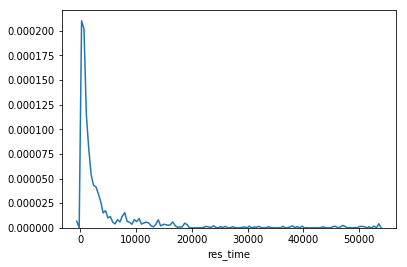

In [571]:
sns.distplot(df_resolved_out, hist=False, bins=100)

We can also do some interquartile analysis. This will tell us where is the 'cut'. 

In [572]:
np.percentile(df_resolved_out, 75)

1124.2616079166667

In [573]:
np.percentile(df_resolved_out, 25)

36.13195458333334

In [574]:
# We decide to cut those deviated observations

df_resolved = df_resolved[df_resolved['res_time'] < 900]
#df_resolved = df_resolved[df_resolved['res_time'] > 36]


In [575]:
#After we've made the cuts, we reset the index
df_resolved = df_resolved.reset_index(drop=True)

In [576]:
df_resolved

,status,priority,issue_type,vote_count,assignee,comment_count,key,watch_count,res_time,month,year,0
0,Resolved,0.50,Improvement,0.000000,0,0.000000,AVRO-2169,0.013514,424.825011,4,2018,2
1,Resolved,0.50,Bug,0.000000,0,0.010309,AVRO-2168,0.013514,449.226710,4,2018,2
2,Resolved,0.50,Bug,0.000000,0,0.000000,AVRO-2167,0.013514,469.909018,4,2018,2
3,Resolved,0.50,Bug,0.000000,0,0.010309,AVRO-2166,0.027027,470.050064,4,2018,2
4,Resolved,0.00,Bug,0.000000,1,0.030928,AVRO-2157,0.027027,130.439272,3,2018,3
5,Resolved,0.00,Bug,0.000000,0,0.051546,AVRO-2152,0.040541,74.222211,3,2018,2
6,Resolved,0.50,Improvement,0.000000,1,0.061856,AVRO-2147,0.040541,314.070273,2,2018,3
7,Resolved,0.50,Improvement,0.000000,1,0.061856,AVRO-2143,0.040541,224.669575,2,2018,3
8,Resolved,0.25,Improvement,0.000000,1,0.030928,AVRO-2133,0.040541,1.132192,1,2018,3
9,Resolved,0.50,Improvement,0.000000,1,0.154639,AVRO-2132,0.067568,856.621358,1,2018,2


# Model Training

In [577]:
#One Hot Encoding of categorical values and definition of X and y

ohe = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipec = Pipeline([ohe])
Xc = df_resolved[['issue_type', 'month']]
Xct = pd.DataFrame(pipec.fit_transform(Xc))
df_resolved = df_resolved.drop('issue_type', 1)

X = pd.concat([df_resolved,Xct],axis=1,sort=False)
y = df_resolved[['res_time']]

In [578]:
#dropping the values that we don't need anymore after the one hot encoding
X = X.drop('status', 1)
X = X.drop('key', 1)
X = X.drop('res_time', 1)
X = X.drop('month', 1)

In [ ]:
X

In [579]:
#Some final adjustments to our x and y
y = y['res_time'].apply(np.ceil) 
#y = y.values.flatten()
X = np.array(X)

# CrossValidation and modelling

In [ ]:


cvStrategy = KFold(n_splits=6, shuffle=True, random_state=42)
scoring = 'r2'

models = [
          RandomForestRegressor(n_estimators=500, n_jobs=-1),
           linear_model.Lasso(),
          linear_model.LinearRegression()
          ]

for model in models:
    scores = cross_val_score(model, X, y, cv=cvStrategy, scoring=scoring)
    print("\n", model, "\n\n", np.average(scores), "\n")
    

In [ ]:
#We split the data to do the test

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

In [ ]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, Y_train)
predictions = lm.predict(X_test)

In [ ]:
## The line / model
from matplotlib import pyplot as plt
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [ ]:
print("Score:", model.score(X_test, Y_test))

# Predicting Empty values

In [580]:
df_unresolved = df_unresolved.reset_index(drop=True)

In [581]:
#One Hot Encoding of categorical values and definition of X and y

ohe_1 = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipec_1 = Pipeline([ohe])
Xc_1 = df_unresolved[['issue_type', 'month']]
Xct_1 = pd.DataFrame(pipec_1.fit_transform(Xc_1))
df_unresolved = df_unresolved.drop('issue_type', 1)

Xnew = pd.concat([df_unresolved,Xct_1],axis=1,sort=False)

In [582]:
Xnew

,status,priority,vote_count,assignee,comment_count,key,watch_count,res_time,month,year,...,9,10,11,12,13,14,15,16,17,18
0,In Progress,0.50,0.000000,1,0.010309,AVRO-2171,0.013514,NaN,4,2018,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,In Progress,0.25,0.000000,1,0.010309,AVRO-2170,0.027027,NaN,4,2018,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Patch Available,0.25,0.000000,0,0.010309,AVRO-2165,0.013514,NaN,4,2018,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Open,0.50,0.000000,0,0.061856,AVRO-2164,0.054054,NaN,3,2018,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Open,0.50,0.000000,1,0.000000,AVRO-2163,0.013514,NaN,3,2018,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Open,0.50,0.000000,0,0.113402,AVRO-2162,0.040541,NaN,3,2018,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Patch Available,0.50,0.000000,0,0.010309,AVRO-2161,0.013514,NaN,3,2018,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Open,0.75,0.000000,0,0.000000,AVRO-2160,0.013514,NaN,3,2018,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Open,0.50,0.027778,0,0.000000,AVRO-2159,0.027027,NaN,3,2018,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Open,0.25,0.000000,0,0.000000,AVRO-2158,0.013514,NaN,3,2018,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [583]:
#dropping the values that we don't need anymore after the one hot encoding
Xnew = Xnew.drop('status', 1)
Xnew = Xnew.drop('key', 1)
Xnew = Xnew.drop('month', 1)
Xnew = Xnew.drop('res_time', 1)

In [ ]:
Xnew

In [584]:
#type(y)

##y = np.array(y)
#m = np.shape(X)
#y = y.reshape(m)


model = linear_model.LinearRegression() 
#model = linear_model.Ridge(alpha=1) 
#model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
#model = svm.SVR(kernel='linear', C=1e3, degree=2)

model.fit(X, y)
# new instances where we do not know the answer

# make a prediction
ynew = model.predict(Xnew)
# show the inputs and predicted outputs

pred_column = []

for i in range(len(Xnew)):
#    print(ynew[i])
    pred_column.append(ynew[i])

#predictions = fut
#predictions['Prediction'] = pred_column

#predictions['Prediction'].tail()


In [585]:
df_unresolved['res_time'] = pred_column

In [586]:
df_unresolved = df_unresolved[['key', 'res_time']]

In [587]:
df_unresolved

,key,res_time
0,AVRO-2171,224.776998
1,AVRO-2170,224.203288
2,AVRO-2165,211.674486
3,AVRO-2164,268.924129
4,AVRO-2163,131.762840
5,AVRO-2162,318.376017
6,AVRO-2161,192.887075
7,AVRO-2160,155.619325
8,AVRO-2159,285.301742
9,AVRO-2158,214.250345


In [590]:
df

,status,priority,issue_type,vote_count,assignee,comment_count,key,watch_count,res_time,month,year,0
0,In Progress,0.50,Improvement,0.000000,1,0.010309,AVRO-2171,0.013514,NaN,4,2018,3
1,In Progress,0.25,Improvement,0.000000,1,0.010309,AVRO-2170,0.027027,NaN,4,2018,3
2,Resolved,0.50,Improvement,0.000000,0,0.000000,AVRO-2169,0.013514,424.825011,4,2018,2
3,Resolved,0.50,Bug,0.000000,0,0.010309,AVRO-2168,0.013514,449.226710,4,2018,2
4,Resolved,0.50,Bug,0.000000,0,0.000000,AVRO-2167,0.013514,469.909018,4,2018,2
5,Resolved,0.50,Bug,0.000000,0,0.010309,AVRO-2166,0.027027,470.050064,4,2018,2
6,Patch Available,0.25,Improvement,0.000000,0,0.010309,AVRO-2165,0.013514,NaN,4,2018,2
7,Open,0.50,Improvement,0.000000,0,0.061856,AVRO-2164,0.054054,NaN,3,2018,1
8,Open,0.50,Task,0.000000,1,0.000000,AVRO-2163,0.013514,NaN,3,2018,1
9,Open,0.50,Improvement,0.000000,0,0.113402,AVRO-2162,0.040541,NaN,3,2018,1


In [588]:
df_final = df.set_index('key').combine_first(df_unresolved.set_index('key'))

/Users/yotroz/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:7394: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  other.columns, how=join, level=level, return_indexers=True)


In [589]:
df_final

,status,priority,issue_type,vote_count,assignee,comment_count,watch_count,res_time,month,year,0
key,,,,,,,,,,,
AVRO-1,Closed,0.50,Bug,0.000000,1,0.041237,0.000000,430.082877,4,2009,5
AVRO-10,Closed,0.50,Improvement,0.000000,1,0.041237,0.000000,933.108540,4,2009,5
AVRO-100,Closed,0.50,Wish,0.000000,1,0.010309,0.000000,1.904750,8,2009,3
AVRO-1000,Closed,0.50,Bug,0.000000,1,0.030928,0.013514,84.726669,1,2012,4
AVRO-1001,Closed,0.50,Improvement,0.000000,0,0.113402,0.000000,419.564464,1,2012,3
AVRO-1002,Closed,0.50,Bug,0.000000,1,0.010309,0.013514,15.424411,1,2012,3
AVRO-1003,Closed,0.50,Bug,0.000000,1,0.020619,0.000000,45.859028,1,2012,3
AVRO-1004,Closed,0.50,Bug,0.000000,1,0.020619,0.000000,45.797913,1,2012,3
AVRO-1005,Closed,0.25,Improvement,0.000000,1,0.041237,0.000000,337.143608,1,2012,4


In [591]:
exporter = df_final.merge(df_copy, on='key', how='left')


In [601]:
from datetime import timedelta


In [609]:

exporter['created'] = pd.to_datetime(exporter['created'])


In [638]:
exporter

,key,status_x,priority_x,issue_type_x,vote_count_x,assignee_x,comment_count_x,watch_count_x,res_time,month,...,resolutiondate,vote_count_y,project,assignee_y,comment_count_y,description_length,summary_length,watch_count_y,resolution,days_in_current_status
0,AVRO-1,Closed,0.50,Bug,0.000000,1,0.041237,0.000000,430.082877,4,...,2009-04-27T20:14:06.572+0000,0,AVRO,cutting,4,208.0,54,0,Fixed,3207.348102
1,AVRO-10,Closed,0.50,Improvement,0.000000,1,0.041237,0.000000,933.108540,4,...,2009-05-22T17:48:49.311+0000,0,AVRO,cutting,4,247.0,19,0,Fixed,3207.348093
2,AVRO-100,Closed,0.50,Wish,0.000000,1,0.010309,0.000000,1.904750,8,...,2009-08-18T22:29:30.782+0000,0,AVRO,cutting,1,145.0,55,0,Fixed,3143.360851
3,AVRO-1000,Closed,0.50,Bug,0.000000,1,0.030928,0.013514,84.726669,1,...,2012-01-23T23:32:05.045+0000,0,AVRO,cutting,3,352.0,52,1,Fixed,2262.267338
4,AVRO-1001,Closed,0.50,Improvement,0.000000,0,0.113402,0.000000,419.564464,1,...,2012-02-07T05:29:28.777+0000,0,AVRO,NaN,11,402.0,44,0,Duplicate,2262.265288
5,AVRO-1002,Closed,0.50,Bug,0.000000,1,0.010309,0.013514,15.424411,1,...,2012-01-24T21:35:38.646+0000,0,AVRO,cutting,1,350.0,28,1,Fixed,2262.267289
6,AVRO-1003,Closed,0.50,Bug,0.000000,1,0.020619,0.000000,45.859028,1,...,2012-01-26T14:00:15.205+0000,0,AVRO,dcreager,2,537.0,61,0,Fixed,2262.267306
7,AVRO-1004,Closed,0.50,Bug,0.000000,1,0.020619,0.000000,45.797913,1,...,2012-01-26T14:02:24.455+0000,0,AVRO,dcreager,2,231.0,50,0,Fixed,2262.267264
8,AVRO-1005,Closed,0.25,Improvement,0.000000,1,0.041237,0.000000,337.143608,1,...,2012-02-07T22:41:31.398+0000,0,AVRO,craigtlandry,4,NaN,51,0,Fixed,2262.267356
9,AVRO-1006,Closed,0.50,New Feature,0.000000,1,0.412371,0.189189,1022.345087,1,...,2012-03-07T21:02:00.996+0000,0,AVRO,raymie,40,155.0,29,14,Fixed,2144.465136


In [614]:
dates = exporter['created']

In [616]:
type(dates)

pandas.core.series.Series

In [619]:
dates = dates.tolist()

In [621]:
type(dates)

list

In [610]:
times = exporter['res_time']

In [611]:
times = times.tolist()

In [618]:
type(times)

list

In [635]:
work = []
i = 0
for date in dates: 
    work.append(pd.to_datetime(date) + timedelta(hours =times[i]))
    i = i + 1

In [637]:
len(work)

2166

In [633]:
len(dates)

2166

In [632]:
len(times)

2166

In [643]:
exporter['resolution_date'] = work

In [647]:
exporter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166 entries, 0 to 2165
Data columns (total 29 columns):
key                       2166 non-null object
status_x                  2166 non-null object
priority_x                2166 non-null float64
issue_type_x              2166 non-null object
vote_count_x              2166 non-null float64
assignee_x                2166 non-null int64
comment_count_x           2166 non-null float64
watch_count_x             2166 non-null float64
res_time                  2166 non-null float64
month                     2166 non-null int64
year                      2166 non-null int64
0                         2166 non-null int64
status_y                  2166 non-null object
priority_y                2166 non-null object
updated                   2166 non-null object
issue_type_y              2166 non-null object
reporter                  2166 non-null object
created                   2166 non-null datetime64[ns]
resolutiondate            1515 non-nul

In [649]:

exporter = exporter[['status_x', 'priority_x', 'updated',
                     'issue_type_x', 'reporter', 'created',
                     'resolution_date', 'vote_count_x', 'project', 'assignee_x', 'comment_count_x', 'key', 'description_length', 'summary_length', 'watch_count_x', 'resolution', 'days_in_current_status']]

In [653]:
exporter = exporter.rename({'status_x': 'status', 'priority_x': 'priority', 
                            'issue_type_x': 'issue_type', 'vote_count_x': 'vote_count', 
                           'assignee_x': 'assignee', 'comment_count_x':'comment_count',
                            'watch_count_x': 'watch_count'
                           }, axis = 1)

In [654]:
exporter

,status,priority,updated,issue_type,reporter,created,resolution_date,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,Closed,0.50,2009-07-14T22:50:07.862+0000,Bug,cutting,2009-04-27 20:14:06.572000,2009-04-27 20:14:06.572000,0.000000,AVRO,1,0.041237,AVRO-1,208.0,54,0.000000,Fixed,3207.348102
1,Closed,0.50,2009-07-14T22:50:08.652+0000,Improvement,cutting,2009-05-22 17:48:49.311000,2009-05-22 17:48:49.311000,0.000000,AVRO,1,0.041237,AVRO-10,247.0,19,0.000000,Fixed,3207.348093
2,Closed,0.50,2009-09-16T22:31:46.361+0000,Wish,sbanacho,2009-08-18 22:29:30.782000,2009-08-18 22:29:30.782000,0.000000,AVRO,1,0.010309,AVRO-100,145.0,55,0.000000,Fixed,3143.360851
3,Closed,0.50,2012-02-15T00:46:25.776+0000,Bug,slebresne,2012-01-23 23:32:05.045000,2012-01-23 23:32:05.045000,0.000000,AVRO,1,0.030928,AVRO-1000,352.0,52,0.013514,Fixed,2262.267338
4,Closed,0.50,2012-02-15T00:49:22.876+0000,Improvement,shaunw,2012-02-07 05:29:28.777000,2012-02-07 05:29:28.777000,0.000000,AVRO,0,0.113402,AVRO-1001,402.0,44,0.000000,Duplicate,2262.265288
5,Closed,0.50,2012-02-15T00:46:30.037+0000,Bug,hammer,2012-01-24 21:35:38.646000,2012-01-24 21:35:38.646000,0.000000,AVRO,1,0.010309,AVRO-1002,350.0,28,0.013514,Fixed,2262.267289
6,Closed,0.50,2012-02-15T00:46:28.595+0000,Bug,dcreager,2012-01-26 14:00:15.205000,2012-01-26 14:00:15.205000,0.000000,AVRO,1,0.020619,AVRO-1003,537.0,61,0.000000,Fixed,2262.267306
7,Closed,0.50,2012-02-15T00:46:32.158+0000,Bug,dcreager,2012-01-26 14:02:24.455000,2012-01-26 14:02:24.455000,0.000000,AVRO,1,0.020619,AVRO-1004,231.0,50,0.000000,Fixed,2262.267264
8,Closed,0.25,2012-02-15T00:46:24.201+0000,Improvement,craigtlandry,2012-02-07 22:41:31.398000,2012-02-07 22:41:31.398000,0.000000,AVRO,1,0.041237,AVRO-1005,NaN,51,0.000000,Fixed,2262.267356
9,Closed,0.50,2014-06-21T13:56:52.146+0000,New Feature,raymie,2012-03-07 21:02:00.996000,2012-03-07 21:02:00.996000,0.000000,AVRO,1,0.412371,AVRO-1006,155.0,29,0.189189,Fixed,2144.465136


In [655]:
exporter.to_csv('/Users/yotroz/Desktop/avroissuespred.csv', sep=';')
